# Carregando os arquivos:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
dir_annotations = '/content/drive/MyDrive/Trabalho Final - Deep Learning I/annotations/'
dir_images = '/content/drive/MyDrive/Trabalho Final - Deep Learning I/images/'

In [ ]:
anotacoes = sorted(os.listdir(dir_annotations))
imagens = sorted(os.listdir(dir_images))

# Selecionando apenas as imagens que apresentam marcações de rodas:

Nem todas as imagens e arquivos nas pastas apresentam fotos de carro com a roda visível, logo, imagens que não possuem o objeto alvo (roda) aparecendo, devem
ser ignoradas e não devem ser levadas em conta no treinamento e nem
no teste.

In [ ]:
boxes = []

for i in range(400):
    txt = open(dir_annotations + anotacoes[i])
    for line in txt.readlines():
        if line[:][0] == '0':
            boxes.append([i, np.array(line.split()).astype(float)])
            # print(i)

In [ ]:
all_images = []
for idx in range(len(boxes)):
    img = cv2.imread(dir_images + imagens[boxes[idx][0]])
    all_images.append(img / 255)

In [ ]:
(np.array(all_images)).shape # 294 imagens possuem caixas de marcação de roda dentre as 400 primeiras

(294, 360, 640, 3)

**Como não optei por redimensionar o tamanho das imagens originais, 294 foi o número mais seguro que consegui de fotos que contém rodas de carro marcadas, sem ultrapassar o limite de memória do google colab.**

# Separando X e Y para criação do modelo

In [ ]:
x = all_images

In [ ]:
y = []
for i in range(len(boxes)):
    y.append(boxes[i][1][1:5])

In [25]:
y[0]

array([0.3872185, 0.5534815, 0.6884895, 0.0138425])

# Mudando a maneira como a marcação da roda é feita.

Os 4 números indicam as coordenadas de localização da
roda no formato YOLO. Ou seja, os dois primeiros números são as
coordenadas x e y do centro do objeto e as duas últimas são a largura e
altura do objeto.

Disso:
* y[0][0] -> X
* y[0][1] -> Y
* y[0][2] -> Largura
* y[0][3] -> Altura

para isso:
* y[0][0] -> x inicial
* y[0][1] -> y inicial
* y[0][2] -> x final
* y[0][3] -> y final

exemplo: [0.3872185, 0.5534815, 0.6884895, 0.0138425] se torna [0.3872185, 0.5534815, 0.6884895, 0.0138425].

In [ ]:
for i in range(len(y)):
    y[i][0] = (y[i][0] - (y[i][2] / 2)) # valor de x inicial
    y[i][1] = (y[i][1] + (y[i][3] / 2)) # valor de y inicial
    y[i][2] = (y[i][0] + y[i][2]) # valor de x final
    y[i][3] = (y[i][1] - y[i][3]) # valor de y final

In [ ]:
x = np.array(x)
y = np.array(y)

In [ ]:
print(x.shape)
print(y.shape)

print(x[0])
print(y[0])

(294, 360, 640, 3)
(294, 4)
[[[0.28627451 0.26666667 0.23137255]
  [0.29411765 0.2745098  0.23921569]
  [0.30196078 0.2745098  0.23921569]
  ...
  [0.61568627 0.58823529 0.64705882]
  [0.61960784 0.58039216 0.64313725]
  [0.61568627 0.57647059 0.63921569]]

 [[0.27058824 0.25098039 0.21568627]
  [0.27058824 0.25098039 0.21568627]
  [0.25882353 0.23137255 0.19607843]
  ...
  [0.61960784 0.59215686 0.65098039]
  [0.62745098 0.58823529 0.65098039]
  [0.62352941 0.58431373 0.64705882]]

 [[0.29411765 0.2745098  0.23921569]
  [0.29411765 0.2745098  0.23921569]
  [0.27843137 0.25882353 0.22352941]
  ...
  [0.63529412 0.6        0.65098039]
  [0.63529412 0.6        0.65098039]
  [0.63529412 0.6        0.65098039]]

 ...

 [[0.38823529 0.40784314 0.41176471]
  [0.38823529 0.40784314 0.41176471]
  [0.38823529 0.40392157 0.40784314]
  ...
  [0.98823529 0.98823529 0.98823529]
  [0.98823529 0.98823529 0.98823529]
  [0.98823529 0.98823529 0.98823529]]

 [[0.40784314 0.42352941 0.42745098]
  [0.4117

In [ ]:
#Função para visualizar as fotos devidamente marcadas:
def show_mark(img, box):
    img2 = cv2.rectangle(
        img.copy() * 255,
        [(box[0] * 640).astype(int), (box[1] * 360).astype(int)],
        [(box[2] * 640).astype(int), (box[3] * 360).astype(int)],
        (0,255,0),
        2
        )
    cv2_imshow(img2)

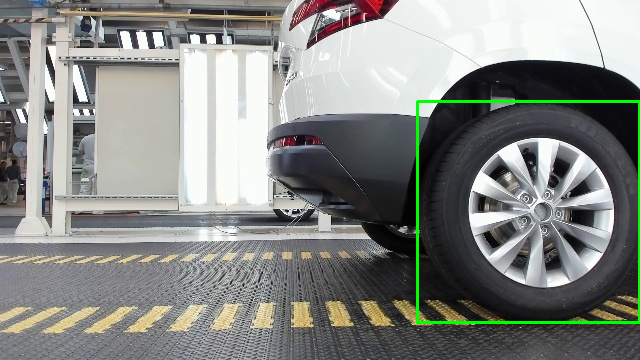

In [ ]:
show_mark(x[214], y[214])

# Separando amostras de treino e de teste: 

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(235, 360, 640, 3)
(59, 360, 640, 3)
(235, 4)
(59, 4)


# Desenvolvimento do Modelo:

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='sigmoid'))

In [ ]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [ ]:
model.fit(
    x_train,
    y_train,
    batch_size=8,
    epochs=100
)

Epoch 1/100
30/30 [==============================] - 7s 76ms/step - loss: 0.1472 - mae: 0.2859
Epoch 2/100
30/30 [==============================] - 2s 66ms/step - loss: 0.1497 - mae: 0.2825
Epoch 3/100
30/30 [==============================] - 2s 66ms/step - loss: 0.1497 - mae: 0.2825
Epoch 4/100
30/30 [==============================] - 2s 66ms/step - loss: 0.1497 - mae: 0.2825
Epoch 5/100
30/30 [==============================] - 2s 68ms/step - loss: 0.1497 - mae: 0.2825
Epoch 6/100
30/30 [==============================] - 2s 73ms/step - loss: 0.1497 - mae: 0.2825
Epoch 7/100
30/30 [==============================] - 2s 71ms/step - loss: 0.1497 - mae: 0.2825
Epoch 8/100
30/30 [==============================] - 2s 68ms/step - loss: 0.1497 - mae: 0.2825
Epoch 9/100
30/30 [==============================] - 2s 66ms/step - loss: 0.1497 - mae: 0.2825
Epoch 10/100
30/30 [==============================] - 2s 66ms/step - loss: 0.1497 - mae: 0.2825
Epoch 11/100
30/30 [=============================

In [ ]:
loss, acc = model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 75ms/step


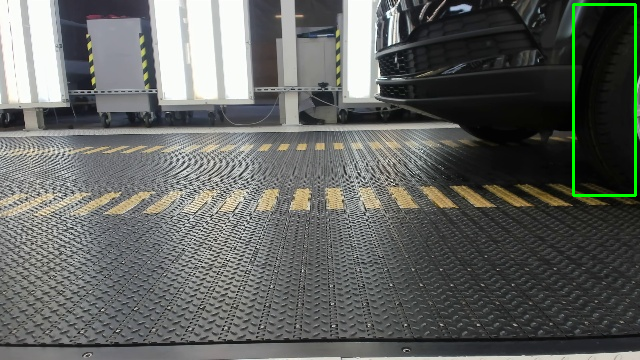

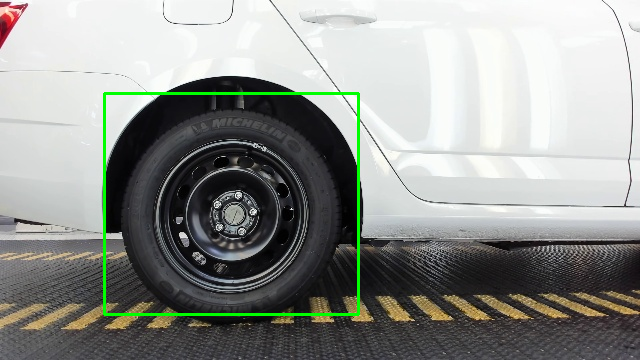

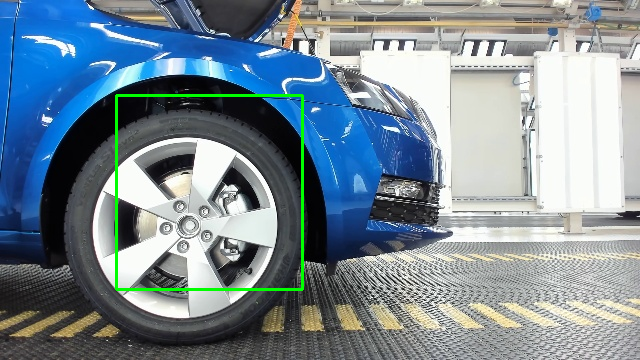

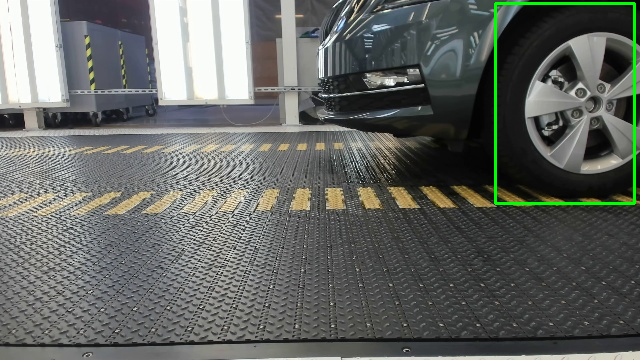

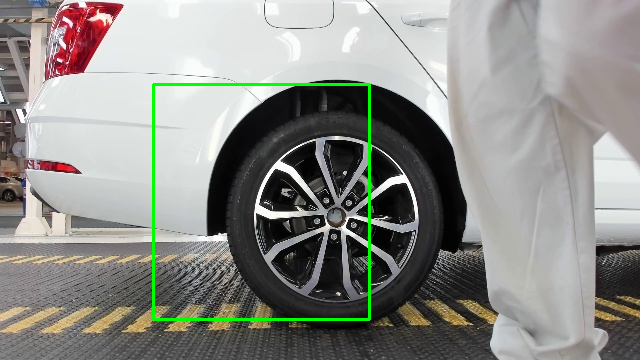

In [26]:
y_pred = model.predict(x_test)

for img, box in zip(x_test[:5], y_pred[:5]):
    show_mark(img, box)